# S1W3D2 (Day 16): 数据集加载与预处理

**🎯 今日目标**

1.  **理解 Transforms**：学会将原始图片转换为模型能吃的 Tensor，并进行归一化。
2.  **使用 Torchvision**：自动下载并加载 MNIST 数据集。
3.  **构建 DataLoader**：实现数据的批量读取 (Batching) 和打乱 (Shuffling)。
4.  **封装 utils.py**：将数据加载逻辑封装成函数，供后续使用。

## 定义数据变换（Transforms）

> **面试考点**：原始图片（0-255 的整数）是不能直接喂给神经网络的，必须转换成浮点数 Tensor，且通常需要归一化。

In [1]:
import torch
from torchvision import transforms

# 定义转换操作序列
# transforms.Compose 像一个“流水线”，把多个操作串起来
transform = transforms.Compose([
    
    transforms.ToTensor(),  # 1. 将 PIL 图片 (H, W, C) 0-255 转换为 Tensor (C, H, W) 0.0-1.0
    transforms.Normalize((0.1307,), (0.3081,)) # 2. 归一化 (减均值，除方差)
])

# 💡 知识点补充：
# 0.1307 和 0.3081 是 MNIST 数据集计算出来的全局均值和标准差。
# 归一化后，数据会变成以 0 为中心的正态分布，有利于模型更快收敛。

## 📥 加载数据集 (Dataset)

> 我们使用 `torchvision.datasets` 来自动处理下载和读取。

In [4]:
from torchvision import datasets

# 1. 下载并加载训练集
# root='./data': 数据存放在当前目录下的 data 文件夹
# train=True: 加载训练集 (60,000 张)
# download=True: 如果没数据就自动下载
train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)

# 2. 下载并加载测试集
# train=False: 加载测试集 (10,000 张)
test_dataset = datasets.MNIST(root='../../data', train=False, download=True, transform=transform)

print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# 查看一条数据
image, label = train_dataset[0]
print(f"单张图片形状: {image.shape}") # 应该是 [1, 28, 28]
print(f"对应的标签: {label}")

训练集大小: 60000
测试集大小: 10000
单张图片形状: torch.Size([1, 28, 28])
对应的标签: 5


## 🚚 构建数据加载器 (DataLoader)

> **Dataset** 只是把数据读进来了（像仓库），**DataLoader** 负责把数据打包成一个个 Batch 发给模型（像传送带）。

In [5]:
from torch.utils.data import DataLoader

# 批次大小 (Batch Size)：一次训练多少张图
BATCH_SIZE = 64

# 训练集加载器：必须 shuffle=True (打乱顺序)，防止模型死记硬背
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 测试集加载器：通常 shuffle=False (不需要打乱，因为不需要更新参数)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 检查 DataLoader ---
# 获取第一个 batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch Images Shape: {images.shape}") 
# 预期: [64, 1, 28, 28] (64张图，单通道，28x28)
print(f"Batch Labels Shape: {labels.shape}") 
# 预期: [64] (64个标签)

Batch Images Shape: torch.Size([64, 1, 28, 28])
Batch Labels Shape: torch.Size([64])


## 📦 封装到 `utils.py` (关键任务)

我们将刚才的代码封装成一个函数，这样明天写 `train.py` 时，一行代码就能搞定数据。

**请将以下代码复制到 `utils.py` 中：**

```python
# utils.py
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_data_loaders(batch_size=64):
    """
    下载并加载 MNIST 数据集，返回 train_loader 和 test_loader
    """
    # 1. 定义变换
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # 2. 加载 Dataset
    # 这里的 root='./data' 意味着数据会下载到你运行脚本的目录下的 data 文件夹
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # 3. 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

if __name__ == "__main__":
    # 简单的测试代码，直接运行 python utils.py 时会执行
    train_loader, _ = get_data_loaders()
    print(f"Train loader ready. Batch size: {train_loader.batch_size}")
```

## ✅ 验证封装是否成功

In [1]:
# 尝试导入我们刚才写的模块
# 注意：如果 utils.py 是刚创建的，可能需要重启一下 Notebook 内核才能识别到
from utils import get_data_loaders

train_loader, test_loader = get_data_loaders(batch_size=32)

print("✅ utils.py 导入成功！")
for images, labels in train_loader:
    print(f"从 utils 获取的 Batch 形状: {images.shape}")
    break # 只看第一个

✅ utils.py 导入成功！
从 utils 获取的 Batch 形状: torch.Size([32, 1, 28, 28])


## 🧠 7. 面试复盘 (理论补充)

在笔记的最后，尝试回答这两个问题（记在心里或写下来）：

1.  **面试官：Dataset 和 DataLoader 有什么区别？**

      * **Dataset**：负责\*\*“取出一张数据”\*\*。它实现了 `__getitem__`，告诉计算机第 $i$ 张图片在哪里，长什么样。
      * **DataLoader**：负责\*\*“调度”\*\*。它调用 Dataset，把数据凑成一个 Batch，负责打乱顺序 (Shuffle)，负责多进程加速 (num\_workers)。

2.  **面试官：为什么要对图像数据做 Normalize (归一化)？**

      * 如果不归一化，像素值是 0-255，数值很大；
      * 如果归一化到 0-1 或 -1 到 1，数据的分布更集中（均值为0，方差为1）；
      * 这能让**梯度下降算法收敛得更快、更稳定**，防止梯度消失或爆炸。



这是第 56 张图片
这张图的标签是: 0


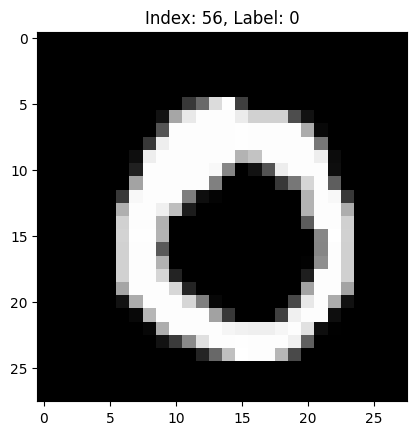

In [26]:
import matplotlib.pyplot as plt

# --- 关键设置 ---
# 你可以在这里填 0 到 59999 之间的任意数字
ANY_INDEX = 56

# 1. 直接从大仓库 (Dataset) 里拿数据，而不是从传送带 (Loader) 拿
# train_loader.dataset 就是那个包含 60,000 张图的对象
image, label = train_loader.dataset[ANY_INDEX]

print(f"这是第 {ANY_INDEX} 张图片")
print(f"这张图的标签是: {label}")

# 2. 还原数据 (反归一化)
# 因为 Dataset 里存的已经是 transform 过的 Tensor 了，还是要做这一步
# img = (pixel - mean) / std
image = image * 0.3081 + 0.1307

# 3. 调整形状 & 转换为 Numpy
# Tensor [1, 28, 28] -> Squeeze [28, 28] -> Numpy
img_numpy = image.squeeze().numpy()

# 4. 画图
plt.imshow(img_numpy, cmap='gray')
plt.title(f"Index: {ANY_INDEX}, Label: {label}")
plt.show()